# Sentinel-3 <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">


* **Products used:** 
[s3_olci_l2_lfr](https://explorer.digitalearth.africa/products/s3_olci_l2_lfr)

## Background



## Description



***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

In [1]:
%matplotlib inline
import datacube
from deafrica_tools.plotting import display_map

In [2]:
dc = datacube.Datacube(app="Sentinel_3")

In [3]:
dc.list_products().loc[dc.list_products()['description'].str.contains('Sentinel-3')]

,name,description,license,default_crs,default_resolution
name,,,,,
s3_ol_2_wfr_nrt,s3_ol_2_wfr_nrt,Sentinel-3 Level 2 Water Full Resolution (WFR)...,CC-BY-4.0,EPSG:4326,"(-0.003, 0.003)"


In [4]:
product = "s3_olci_l2_lfr"

### List measurements

We can further inspect the data available for each SAR product using datacube's `list_measurements` functionality. The table below lists each of the measurements available in the data.

In [5]:
measurements = dc.list_measurements()
measurements.loc[product]

KeyError: 's3_olci_l2_lfr'

In [6]:
latitude = -33.92
longitude = 18.42
buffer = 0.1
time = ('2025-01')

In [7]:
display_map(x=(longitude-buffer, longitude+buffer), y=(latitude+buffer, latitude-buffer))

In [8]:
query = {
    'x': (longitude-buffer, longitude+buffer),
    'y': (latitude+buffer, latitude-buffer),
    'time':time,
    'output_crs': 'EPSG:4326',
    'resolution': (0.003, 0.003)}

In [9]:
ds_S3 = dc.load(product=product,
                group_by="solar_day",
                **query)

print(ds_S3)

<xarray.Dataset> Size: 548kB
Dimensions:      (time: 30, latitude: 67, longitude: 68)
Coordinates:
  * time         (time) datetime64[ns] 240B 2025-01-01T03:52:31.500000 ... 20...
  * latitude     (latitude) float64 536B -34.02 -34.02 -34.01 ... -33.82 -33.82
  * longitude    (longitude) float64 544B 18.32 18.32 18.33 ... 18.52 18.52
    spatial_ref  int32 4B 4326
Data variables:
    GIFAPAR      (time, latitude, longitude) uint8 137kB 0 0 0 0 0 ... 0 0 0 0 0
    IWV_L        (time, latitude, longitude) uint8 137kB 41 31 31 31 ... 22 22 0
    OTCI         (time, latitude, longitude) uint8 137kB 0 0 0 0 0 ... 2 2 2 2 0
    dataMask     (time, latitude, longitude) uint8 137kB 0 0 0 0 0 ... 1 1 0 0 0
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref


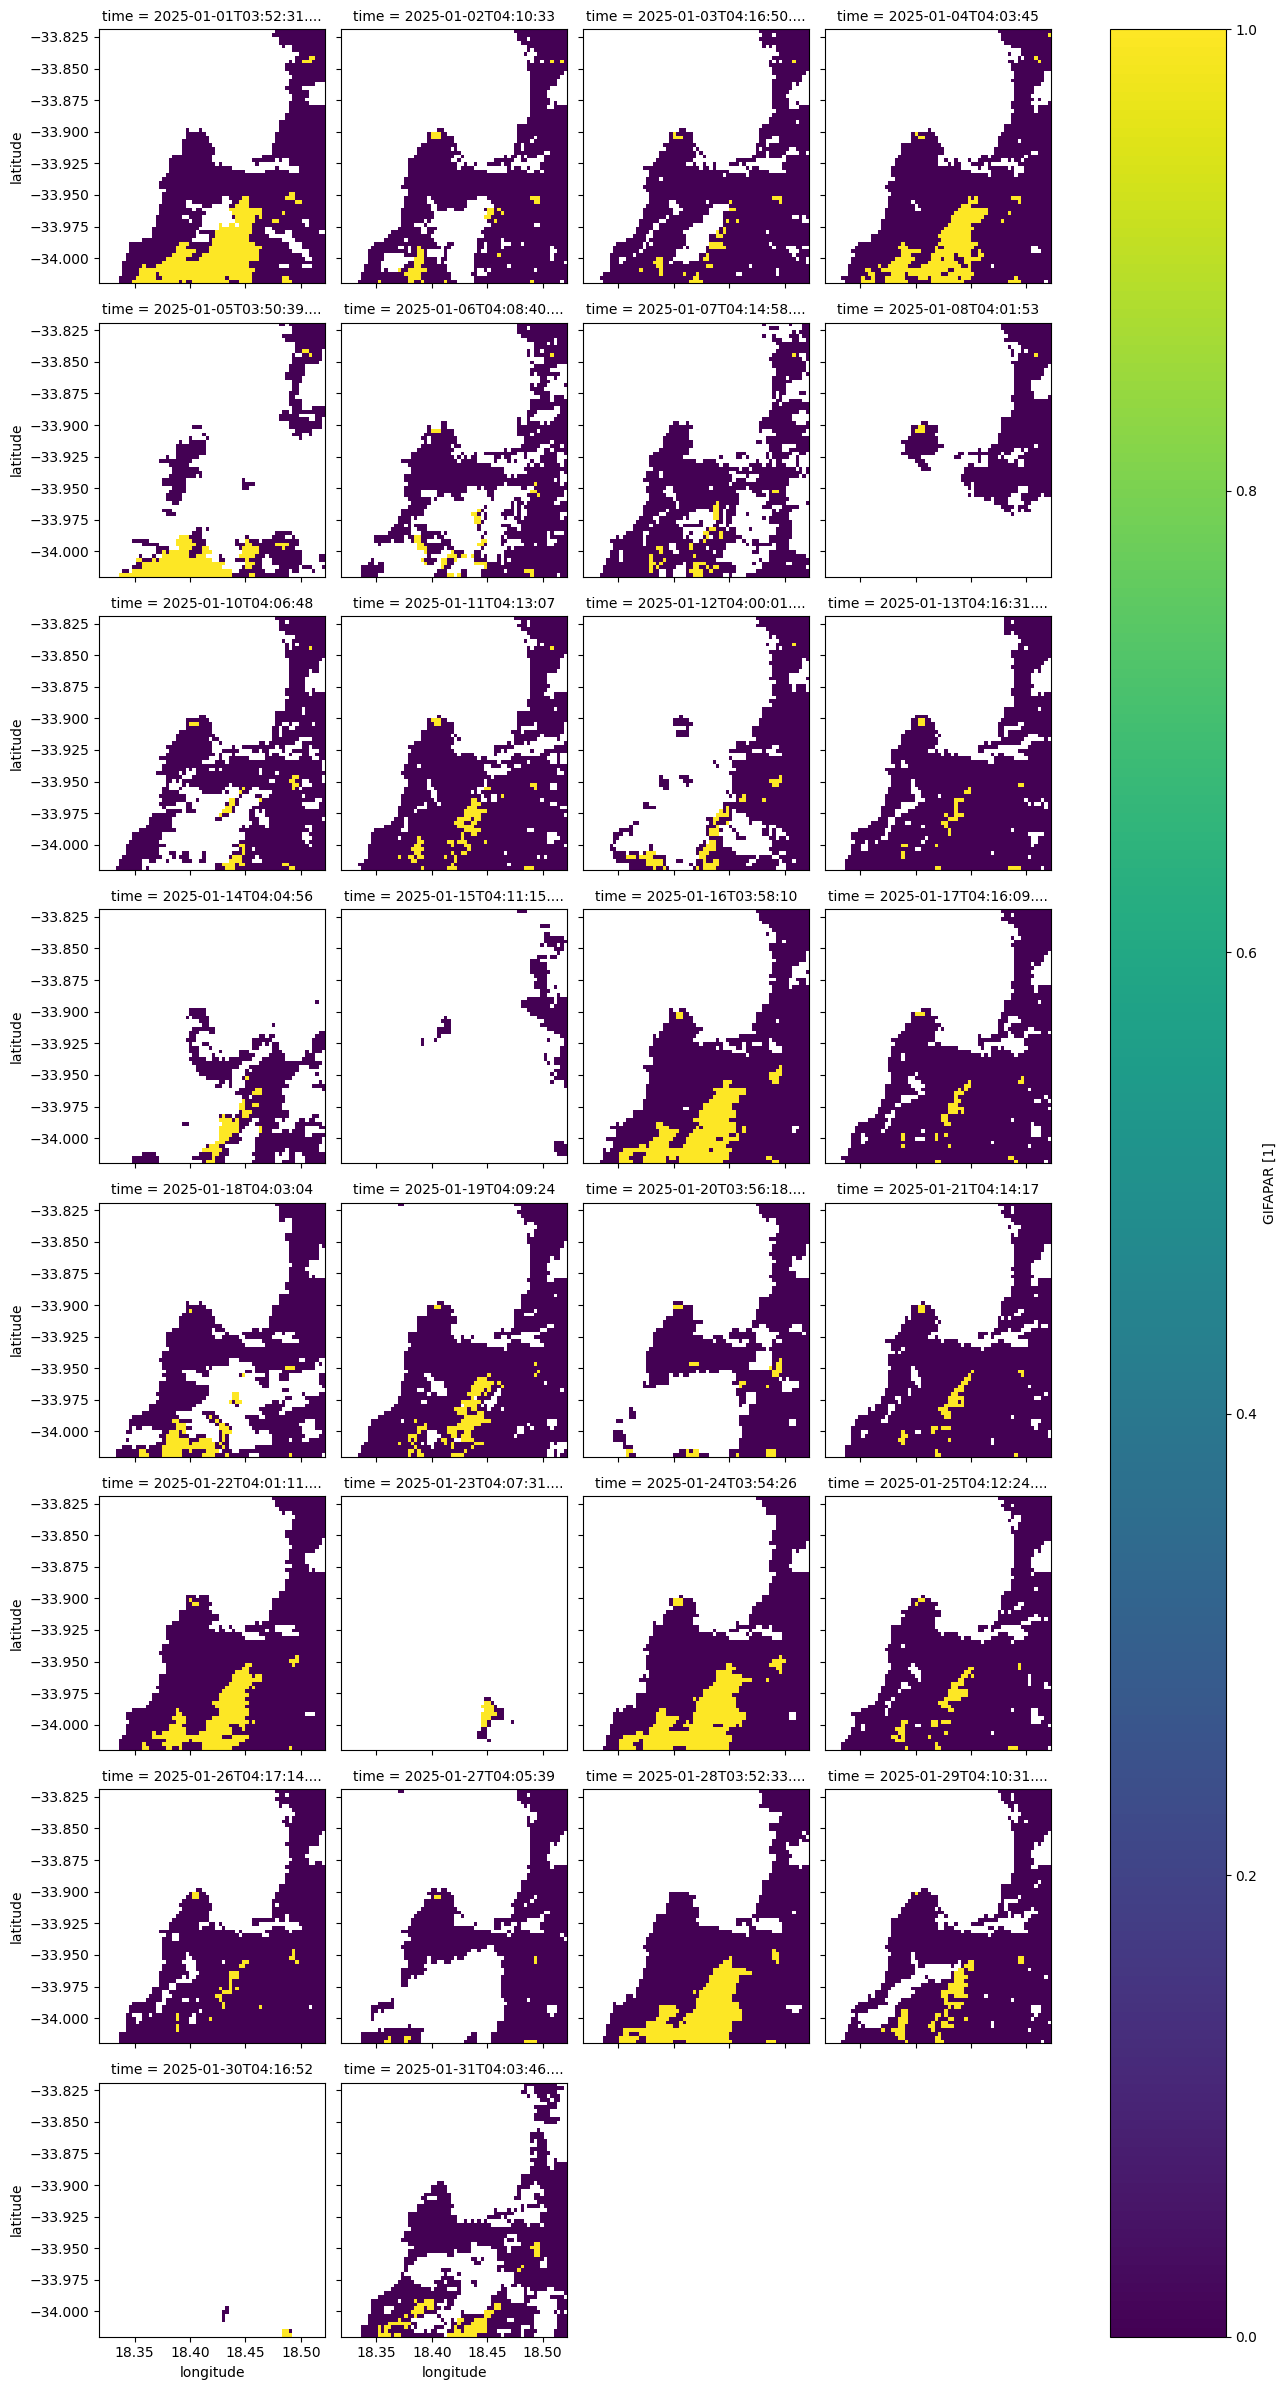

In [10]:
ds_S3.GIFAPAR.where(ds_S3.dataMask==1).plot(robust=True, col="time", col_wrap=4);

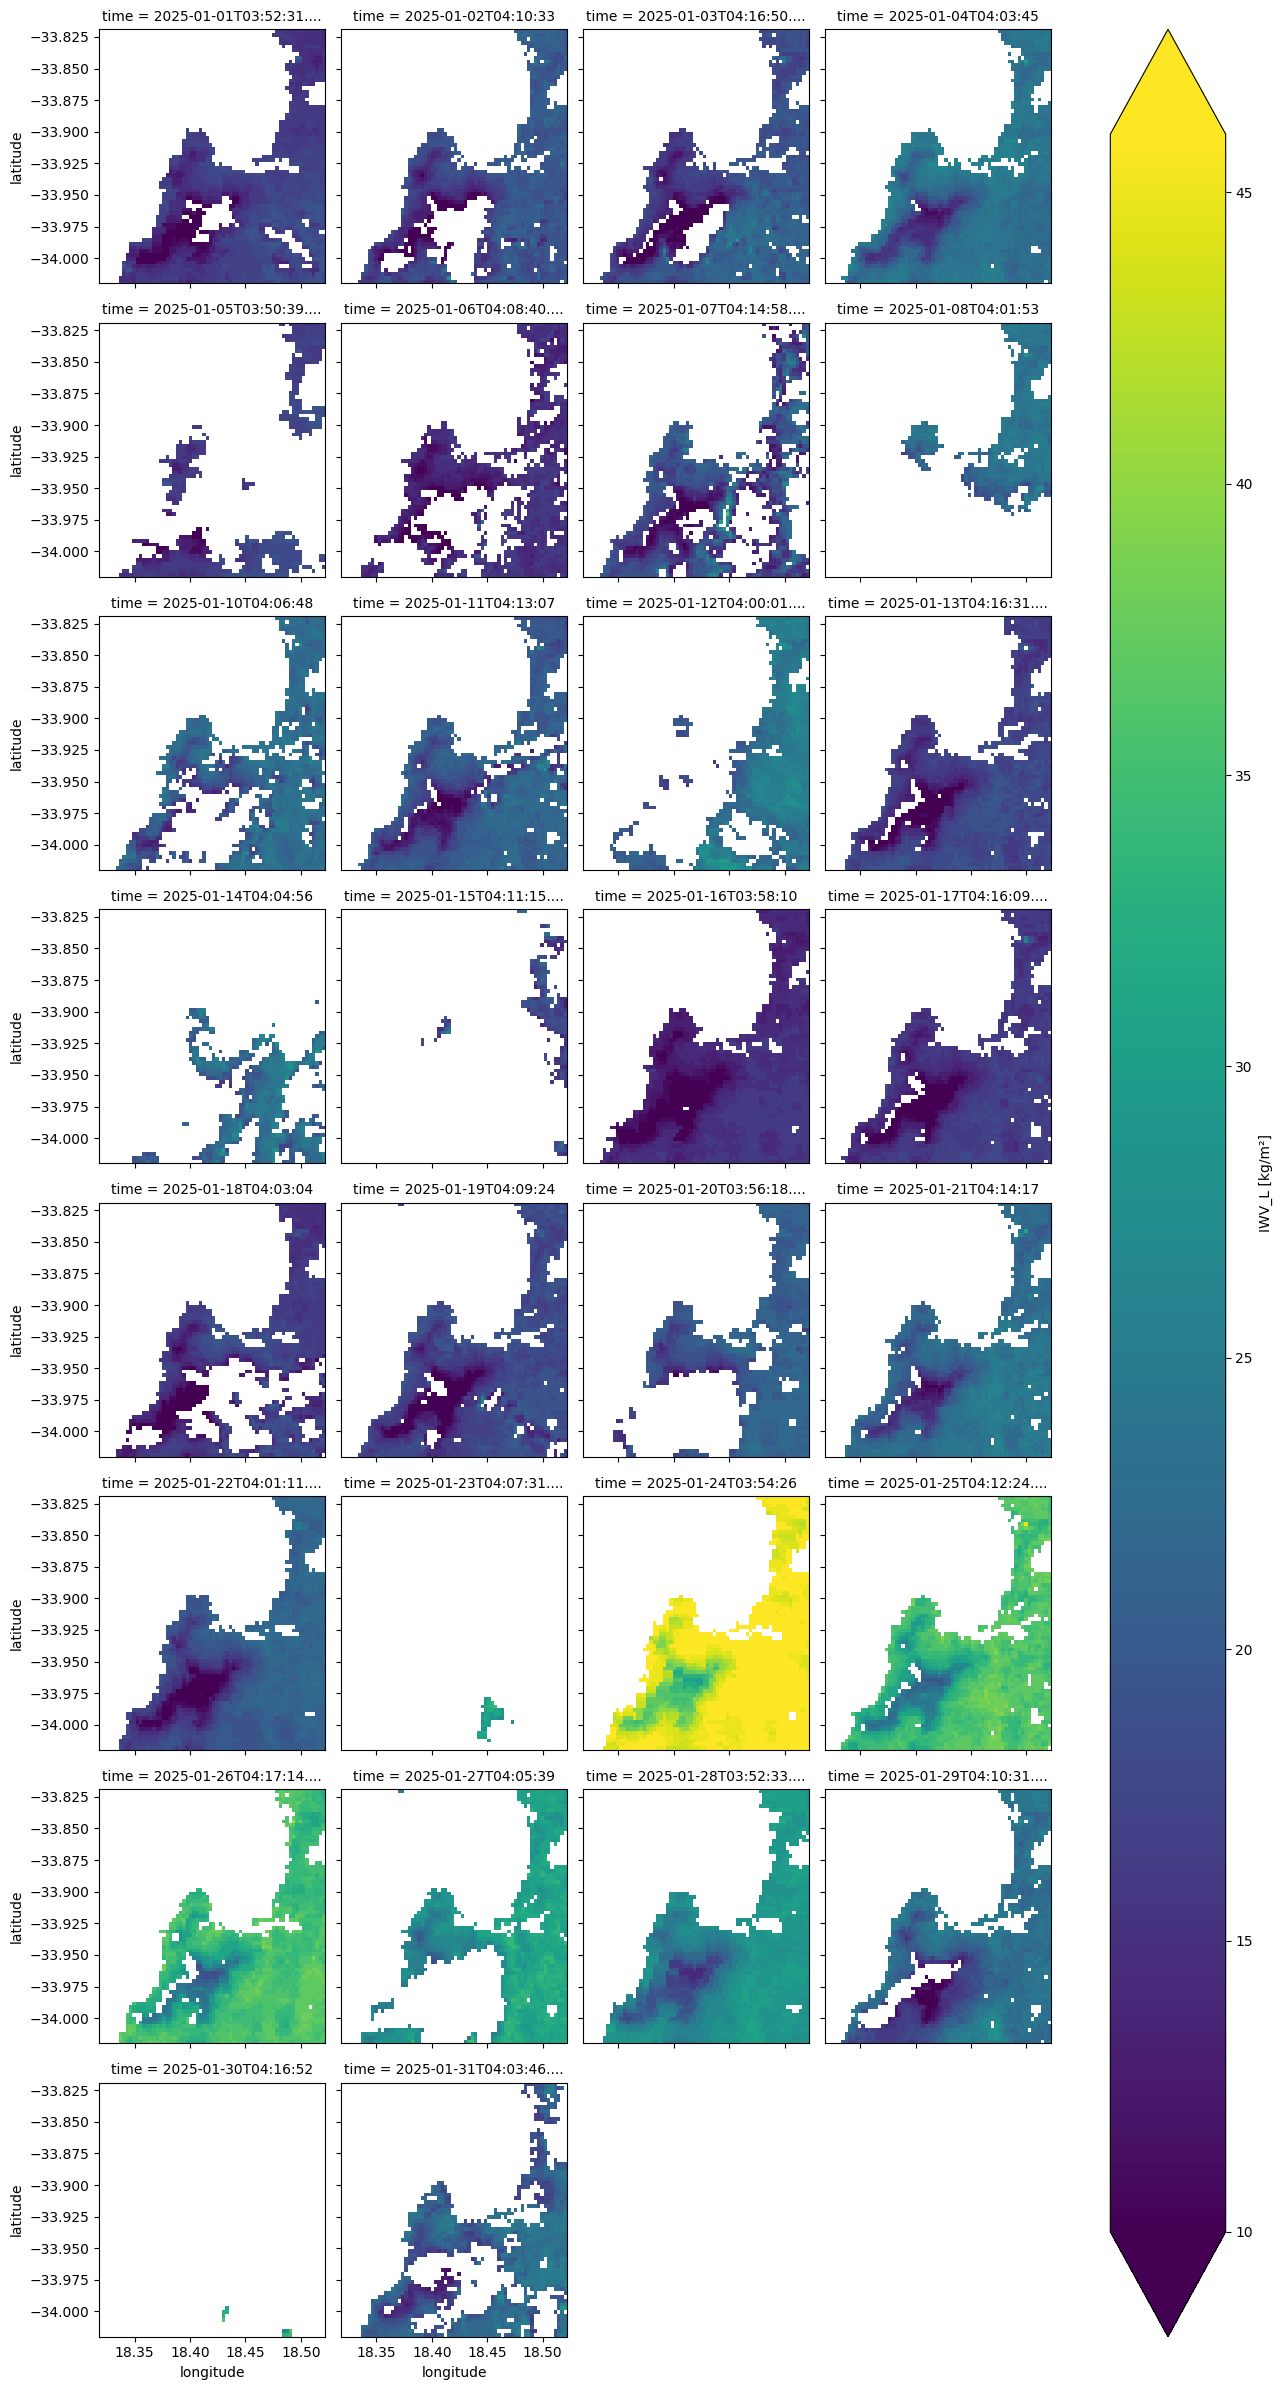

In [11]:
ds_S3.IWV_L.where(ds_S3.dataMask==1).plot(robust=True, col="time", col_wrap=4);

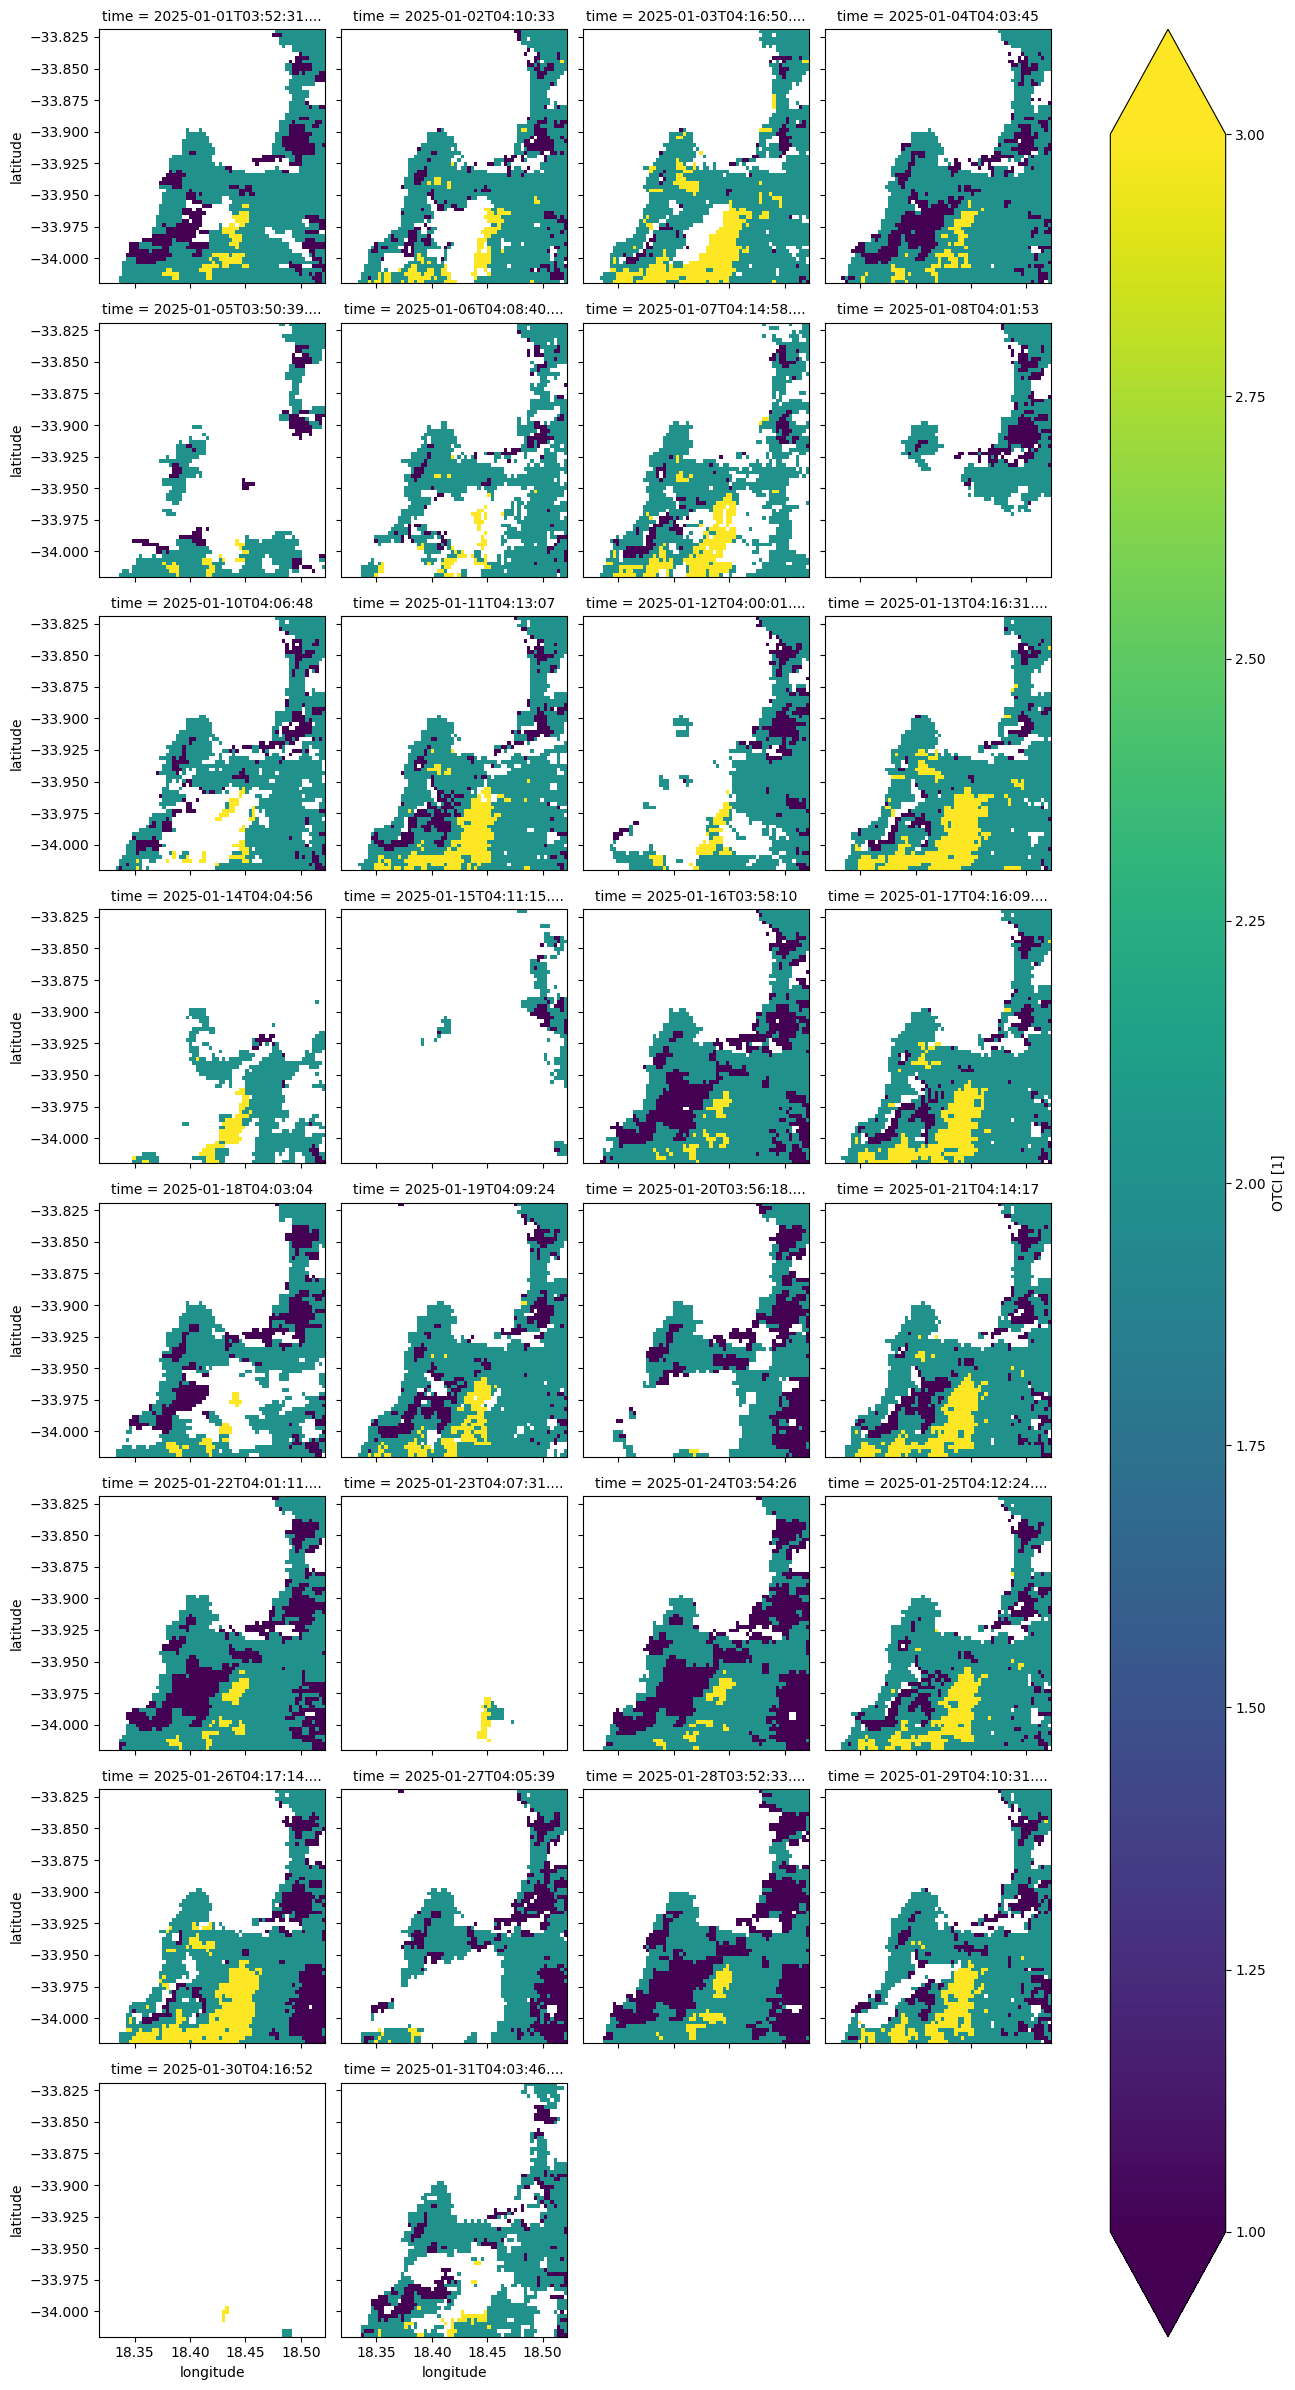

In [12]:
ds_S3.OTCI.where(ds_S3.dataMask==1).plot(robust=True, col="time", col_wrap=4);